In [1]:
from tqdm import tqdm
import tensorflow.compat.v1 as tf
import networkx as nx
from scipy.linalg import block_diag
from subprocess import call
import matplotlib.pyplot as plt
import numpy as np
import os
import re 
import time
import glob
import sys

tf.disable_v2_behavior()
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

W0426 09:00:26.413169 12492 deprecation.py:323] From D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [62]:
graphno,pertseed = 4, 59428#13674#84932#72957#85036 #int(sys.argv[1]),int(sys.argv[2])

In [63]:
metadata = {}
metadata['n_n'] = 1+30             # number of neurons
metadata['p_n'] = 1                  # number of PNs
metadata['l_n'] = 30                  # number of LNs

temp = np.load(f'../modules/matrix_{graphno}.npy')
metadata['fgaba_mat'] = block_diag(np.array([[0]]),temp)
np.fill_diagonal(metadata['fgaba_mat'],0)

metadata['g_gaba'] = 1.5
metadata['sim_res'] = 0.01
n_syn_fgaba = int(metadata['fgaba_mat'].sum())
n_syn_sgaba = 0
n_syn_ach = 0

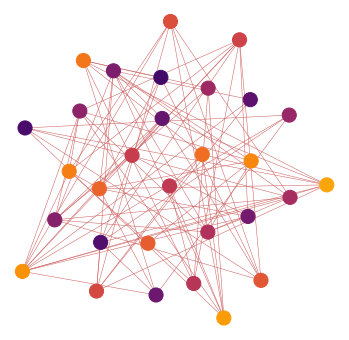

In [64]:
np.random.seed(783385)
plt.figure(figsize=(6,6))
inv_G = nx.from_numpy_matrix(1-metadata['fgaba_mat'][1:,1:],create_using=nx.Graph)
G = nx.from_numpy_matrix(metadata['fgaba_mat'][1:,1:],create_using=nx.Graph)
pos = nx.layout.fruchterman_reingold_layout(inv_G)

M = G.number_of_edges()

nodes = nx.draw_networkx_nodes(G, pos, node_size=200, node_color=plt.cm.inferno(np.linspace(0.2,0.8,30)))
edges = nx.draw_networkx_edges(G, pos, node_size=200, arrowstyle='-|>',
                               arrowsize=10, width=0.5,connectionstyle='arc3, rad=0.1',edge_color='indianred')

ax = plt.gca()
ax.set_axis_off()

plt.savefig(f"Figures/LN_only_graph_{graphno}.svg")
plt.show()

In [65]:
np.random.seed(pertseed)#85036
v = [[0]*31]
elems=[1]*15+[0]*15
np.random.shuffle(elems)
v.append([0]+elems)
for i in range(4):
    np.random.shuffle(elems)
    v.append([0]+elems)
v = np.array(v)

In [66]:
blocktime = 1000 # in ms
buffer = 500 # in ms
sim_res = metadata['sim_res'] # simulation resolution (in ms)
width = int(blocktime/sim_res)
tfilter_base = np.ones(width)
width_red = int(0.1*blocktime/sim_res)
tfilter = np.zeros_like(tfilter_base)
tfilter[:width_red] = 1
sim_time = len(v)*blocktime + 2*buffer # total simulation time (in ms)
t = np.arange(0,sim_time,sim_res)        # duration of simulation
current_input = np.ones((metadata['n_n'],t.shape[0]-int(2*buffer/sim_res)))
for i in range(len(v)):
    current_input[:,i*width:(i+1)*width]=0.0735*current_input[:,i*width:(i+1)*width]*tfilter_base
    current_input[:,i*width:(i+1)*width]+= 0.5*(current_input[:,i*width:(i+1)*width].T*v[i]).T*tfilter
current_input = np.concatenate([np.zeros((current_input.shape[0],int(buffer/sim_res))),current_input,np.zeros((current_input.shape[0],int(buffer/sim_res)))],axis=1)
current_input += 0.05*current_input*np.random.normal(size=current_input.shape)+ 0.001*np.random.normal(size=current_input.shape)
datasets = []
n_reps = 5

In [67]:
for x in range(n_reps):
    state_vector =  [-45]* metadata['p_n']+[-45]* metadata['l_n'] + [0.5]* (metadata['n_n'] + 4*metadata['p_n'] + 3*metadata['l_n']) + [2.4*(10**(-4))]*metadata['l_n'] + [0]*(n_syn_ach+n_syn_fgaba+2*n_syn_sgaba) + [-(sim_time+1)]*metadata['n_n']
    state_vector = np.array(state_vector)
    state_vector = state_vector + 0.005*state_vector*np.random.normal(size=state_vector.shape)

    np.save(f'__simcache__/metadata_{graphno}_{pertseed}.npy',metadata,allow_pickle=True)
    np.save(f'__simcache__/state_vector_{graphno}_{pertseed}',state_vector)
    np.save(f'__simcache__/current_input_{graphno}_{pertseed}',current_input)
    np.save(f'__simcache__/time_{graphno}_{pertseed}',np.array_split(t,4*(len(v)+1)))

    for i in tqdm(range(4*(len(v)+1))):
        call(['python','simple30.py',str(i),str(graphno),str(pertseed)])

    dataset = []
    files = os.listdir('__simoutput__/')
    files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    for i in files:
        dataset.append(np.load(f'__simoutput__/{i}'))

    dataset = np.concatenate(dataset)[:,1:31]
    datasets.append(dataset)
    time.sleep(60)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [26:49<00:00, 57.48s/it]


In [68]:
events = []
for j in range(n_reps):
    temp = datasets[j]
    fire = np.logical_and(temp[:-1,:]<-20,temp[1:,:]>-20)
    event = []
    for i in range(fire.shape[1]):
        event.append(np.arange(temp.shape[0])[:-1][fire[:,i]])
    event = np.array(event,dtype=object)
    events.append(event)
events= np.array(events,dtype=object)

In [69]:
if not os.path.exists("Data/LN30_data_{graphno}_{pertseed}.npy"):
    np.save(f"Data/LN30_data_{graphno}_{pertseed}.npy",datasets,allow_pickle=True)
    np.save(f"Data/LN30_current_{graphno}_{pertseed}.npy",current_input[:,::100],allow_pickle=True)
    np.save(f"Data/LN30_events_{graphno}_{pertseed}.npy",events,allow_pickle=True)
    files = glob.glob('__simcache__/*')
    for f in filter(lambda v: f"{graphno}_{pertseed}" in v,files):
        os.remove(f)
    files = glob.glob('__simoutput__/*')
    for f in filter(lambda v: f"{graphno}_{pertseed}" in v,files):
        os.remove(f)
datasets = np.load(f"Data/LN30_data_{graphno}_{pertseed}.npy",allow_pickle=True)
current_input = np.load(f"Data/LN30_current_{graphno}_{pertseed}.npy",allow_pickle=True)
events = np.load(f"Data/LN30_events_{graphno}_{pertseed}.npy",allow_pickle=True)

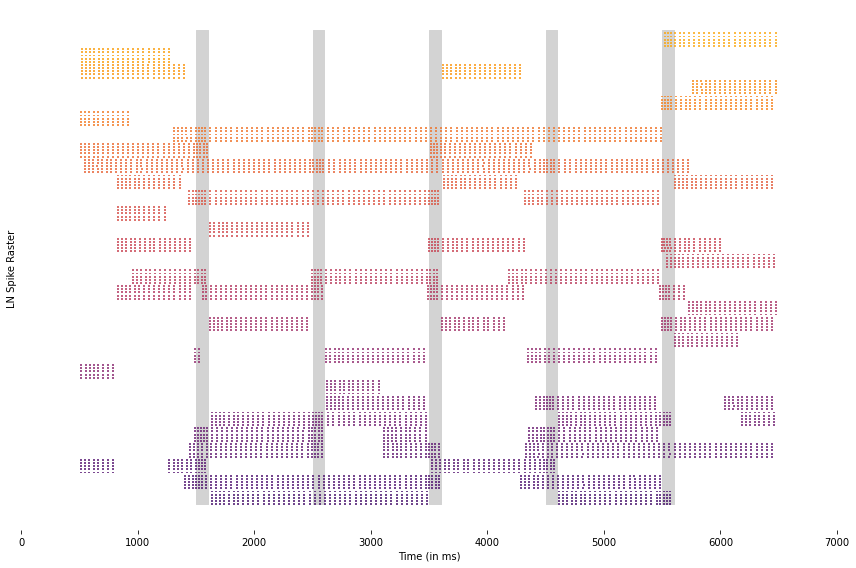

In [70]:
plt.figure(figsize=(12,8))
plt.eventplot(events.T.flatten(),colors=np.tile(plt.cm.inferno(np.linspace(0.2,0.8,30)),5).reshape(-1,4),linelengths=0.6)
for i in range(1500,6500,1000):
    plt.fill_betweenx([0,150],[i,i],[i+100,i+100],color='lightgray')
plt.box(False)
plt.xlim(0,7000)
plt.yticks([])
plt.ylabel('LN Spike Raster')
plt.xlabel('Time (in ms)')
plt.tight_layout()
plt.savefig(f"Figures/LN_only_spiketrains_{graphno}_{pertseed}.svg")
plt.show()

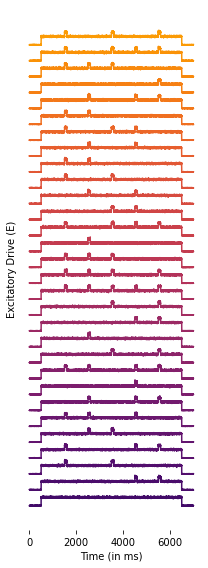

In [71]:
plt.figure(figsize=(3,8))
for i in range(30):
    plt.plot(0.14*i+current_input[i,:],color=plt.cm.inferno(0.2+0.6*(i/30)))
plt.box(False)
plt.yticks([])
plt.ylabel('Excitatory Drive (E)')
plt.xlabel('Time (in ms)')
plt.tight_layout()
plt.savefig(f"Figures/LN_only_current_{graphno}_{pertseed}.svg")